In [1]:
### Pre-reqs (uncomment and run once)
#!pip install kornia
#!pip install git+https://github.com/fastai/fastai_dev@54a9c28d1c856a956698ae8b5ed2fe431f0539aa

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.callback.tracker import *
from fastai2.callback.all     import *
from fastai2.distributed      import *
import pydicom
import torchvision.models as models
import pynvml

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
%config InlineBackend.figure_format = 'retina'

In [4]:
stage = 'stage_2'
experiment = '53_train_cpu_window_uint8'
ARCH = 'resnet18'
FOLD = 4     # 0=1st fold, N_FOLDS-1=last
LR = 1e-4

SZ = 512
N_FOLDS = 5
N_EPOCHS = 15
N_TTA = 10
WC = 100
WW = 254
W_LOSS = 0.1

ram_mb = 11*1024 # (GB * 1024)

# Data

In [5]:
data_dir = Path('data/unzip')
train_dir = data_dir / f'{stage}_train_images'
test_dir = data_dir / f'{stage}_test_images'

In [6]:
fn_to_study_ix = pickle.load(open(f'data/{stage}_fn_to_study_ix.pickle', 'rb'))
study_ix_to_fn = pickle.load(open(f'data/{stage}_study_ix_to_fn.pickle', 'rb'))
study_to_data = pickle.load(open(f'data/{stage}_study_to_data.pickle', 'rb'))
df = pd.read_csv(f"data/{stage}_train_dicom_diags_norm.csv")
df = df.set_index(['fid'])

In [7]:
base_classes = [ 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural' ]
classes = [ f'{l}{s}' for s in range(3) for l in base_classes ]

## Split train/val

In [8]:
folds = np.array_split(list({v['fold'] for v in study_to_data.values()}), N_FOLDS)
folds

[array([0., 1., 2., 3.]),
 array([4., 5., 6., 7.]),
 array([ 8.,  9., 10., 11.]),
 array([12., 13., 14., 15.]),
 array([16., 17., 18.])]

In [9]:
studies_in_fold = [k for k,v in study_to_data.items() if np.isin(v['fold'],folds[FOLD])]
fid_val_set = set(df[ df['SeriesInstanceUID'].isin(studies_in_fold)]['SOPInstanceUID'] + '.dcm')
len(fid_val_set)

117210

In [10]:
def is_val(p_or_fn):
    "return True if file name in validation set"
    p = Path(p_or_fn)
    return p.name in fid_val_set

In [11]:
items = sorted(get_files(train_dir, ['.dcm']))
#assert len(items) == 674257, 'Forgot to delete corrupted ID_6431af929.dcm?'

In [12]:
items[:5]

[PosixPath('data/unzip/stage_2_train_images/ID_000012eaf.dcm'),
 PosixPath('data/unzip/stage_2_train_images/ID_000039fa0.dcm'),
 PosixPath('data/unzip/stage_2_train_images/ID_00005679d.dcm'),
 PosixPath('data/unzip/stage_2_train_images/ID_00008ce3c.dcm'),
 PosixPath('data/unzip/stage_2_train_images/ID_0000950d7.dcm')]

In [13]:
split_idx = FuncSplitter(is_val)(items)

In [14]:
len(split_idx[0]), len(split_idx[1])

(635592, 117210)

## Dicom reader and labeller

In [15]:
def open_dicom(p_or_fn): # when called by .from_folder it's a Path; when called from .add_test it's a string
    #pdb.set_trace()
    center_p = Path(p_or_fn)

    study, center_ix = fn_to_study_ix[center_p.stem]
    total = len(study_ix_to_fn[study])
    
    # Only 1 study has 2 different RescaleIntercept values (0.0 and 1.0) in the same series, so assume they're all the
    # same and do everything in the big tensor
    
    pixels = {}
    ixs = [ max(0, min(ix, total-1)) for ix in range(center_ix-1, center_ix+2) ]
    for ix in ixs:
        if ix not in pixels:
            p = center_p.parent / f'{study_ix_to_fn[study][ix]}.dcm'
            dcm = pydicom.dcmread(str(p))
            if ix == center_ix:
                rescale_slope, rescale_intercept = float(dcm.RescaleSlope), float(dcm.RescaleIntercept)
            pixels[ix] = torch.FloatTensor(dcm.pixel_array.astype(np.float))
        
    t = torch.stack([pixels[ix] for ix in ixs], dim=0) # stack chans together
    if dcm.Rows != 512 or dcm.Columns != 512:
        t = torch.nn.functional.interpolate(t.unsqueeze_(0), size=SZ, mode='nearest').squeeze_(0) # resize (FloatTensors only!)
    t = t * rescale_slope + rescale_intercept # rescale
    t = torch.clamp(t, WC-WW/2, WC+WW/2) # window
    t = (t - (WC-WW/2)) * 255 / WW # normalize
    t = t.to(torch.uint8) # moving uint8 takes less GPU than float32

    return TensorImage(t)

In [16]:
def get_labels(center_p):
    study, center_ix = fn_to_study_ix[center_p.stem]
    total = len(study_ix_to_fn[study])
    
    img_labels = np.array([], dtype=np.float32)
    ixs = [ max(0, min(ix, total-1)) for ix in range(center_ix-1, center_ix+2) ]
    for ix in ixs:
        fn = study_ix_to_fn[study][ix]
        slice_labels = df.loc[fn][base_classes].values.astype(np.float32)
        img_labels = np.append(img_labels, slice_labels)
            
    return img_labels

get_labels(train_dir / 'ID_ac7c8fe8b.dcm')

array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.], dtype=float32)

In [17]:
img = open_dicom(items[555])

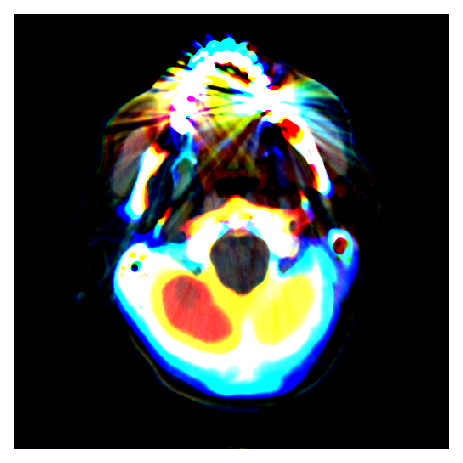

In [18]:
img.show()

In [19]:
# transforms pipelines for [x, y]
tfms = [[open_dicom], [get_labels, EncodedMultiCategorize(classes)]]

In [20]:
dsrc = DataSource(items, tfms, splits=split_idx)

In [21]:
# x, y shapes
dsrc[0][0].dtype, dsrc[0][0].shape, dsrc[0][1].shape

(torch.uint8, torch.Size([3, 512, 512]), torch.Size([18]))

## Transforms and augmentations

In [22]:
class UNUSED_Window(Transform):
    "Apply window"
    def __init__(self, wc, ww): 
        self.wc = wc
        self.ww = ww
        super().__init__()
    def encodes(self, t:(Image.Image, *TensorTypes)): 
        t = torch.clamp(t, self.wc-self.ww/2, self.wc+self.ww/2) # window
        t = (t - (self.wc-self.ww/2)) / self.ww # normalize
        return t

In [23]:
class UNUSED_Float(Transform):
    "Transform image to float tensor"
    order = 20 #Need to run after CUDA if on the GPU
    def __init__(self, split_idx=None, as_item=True):
        super().__init__(split_idx=split_idx,as_item=as_item)

    def encodes(self, o:TensorImage): return o.float()
    def decodes(self, o:TensorImage): return o

## BS calculator

In [24]:
arch_to_batch_factor = {
    'resnet18' : 4.3,
    'resnet34' : 3.4,
    'resnet50' : 1.5,
    'resnet101' : 1.0,
    'resnext50_32x4d': 1.2,
    'densenet121': 1.1,
    'squeezenet1_0': 2.6,
    'vgg16': 1.5
}

mixed = True

#handle = pynvml.nvmlDeviceGetHandleByIndex(torch.cuda.current_device())
#info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    
bs = arch_to_batch_factor[ARCH] * 512 * 512 * ram_mb * 1e-3 / (SZ * SZ)
bs *= 2 if mixed else 1 # int(any([isinstance(cb, MixedPrecision) for cb in learn.callbacks])) + 1 # 2x if fp16
#if any([isinstance(cb, fastai.distributed.ParallelTrainer) for cb in learn.callbacks]):
bs *= torch.cuda.device_count()
bs = (bs // torch.cuda.device_count()) * torch.cuda.device_count()
bs = int(bs)
bs

288

## Normalize data

In [25]:
db = dsrc.databunch(bs=512, after_batch=[ IntToFloatTensor() ])
xb, _ = db.one_batch()
xb.dtype, xb.shape

(torch.float32, torch.Size([512, 3, 512, 512]))

In [26]:
xb[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [27]:
mega_batch_stats = xb.mean(), xb.std()
mega_batch_stats

(tensor(0.1240), tensor(0.2724))

In [28]:
xb = None

In [29]:
batch_tfms = [
    Cuda(),   # 0
    IntToFloatTensor(),  # 20, uint8 -> float32 and divide by 255
    Rotate(180, p=1., mode='nearest'), # 30
    Flip(p=.5, mode='nearest'), # 30 
    Normalize(*mega_batch_stats) # 99
]

In [30]:
db = dsrc.databunch(bs=bs, after_batch=batch_tfms)

In [31]:
%%time
xb,yb = to_cpu(db.one_batch())

CPU times: user 49.6 s, sys: 2.87 s, total: 52.4 s
Wall time: 4.29 s


In [32]:
xb.dtype, xb.mean(), xb.std()

(torch.float32, tensor(0.0154), tensor(1.0126))

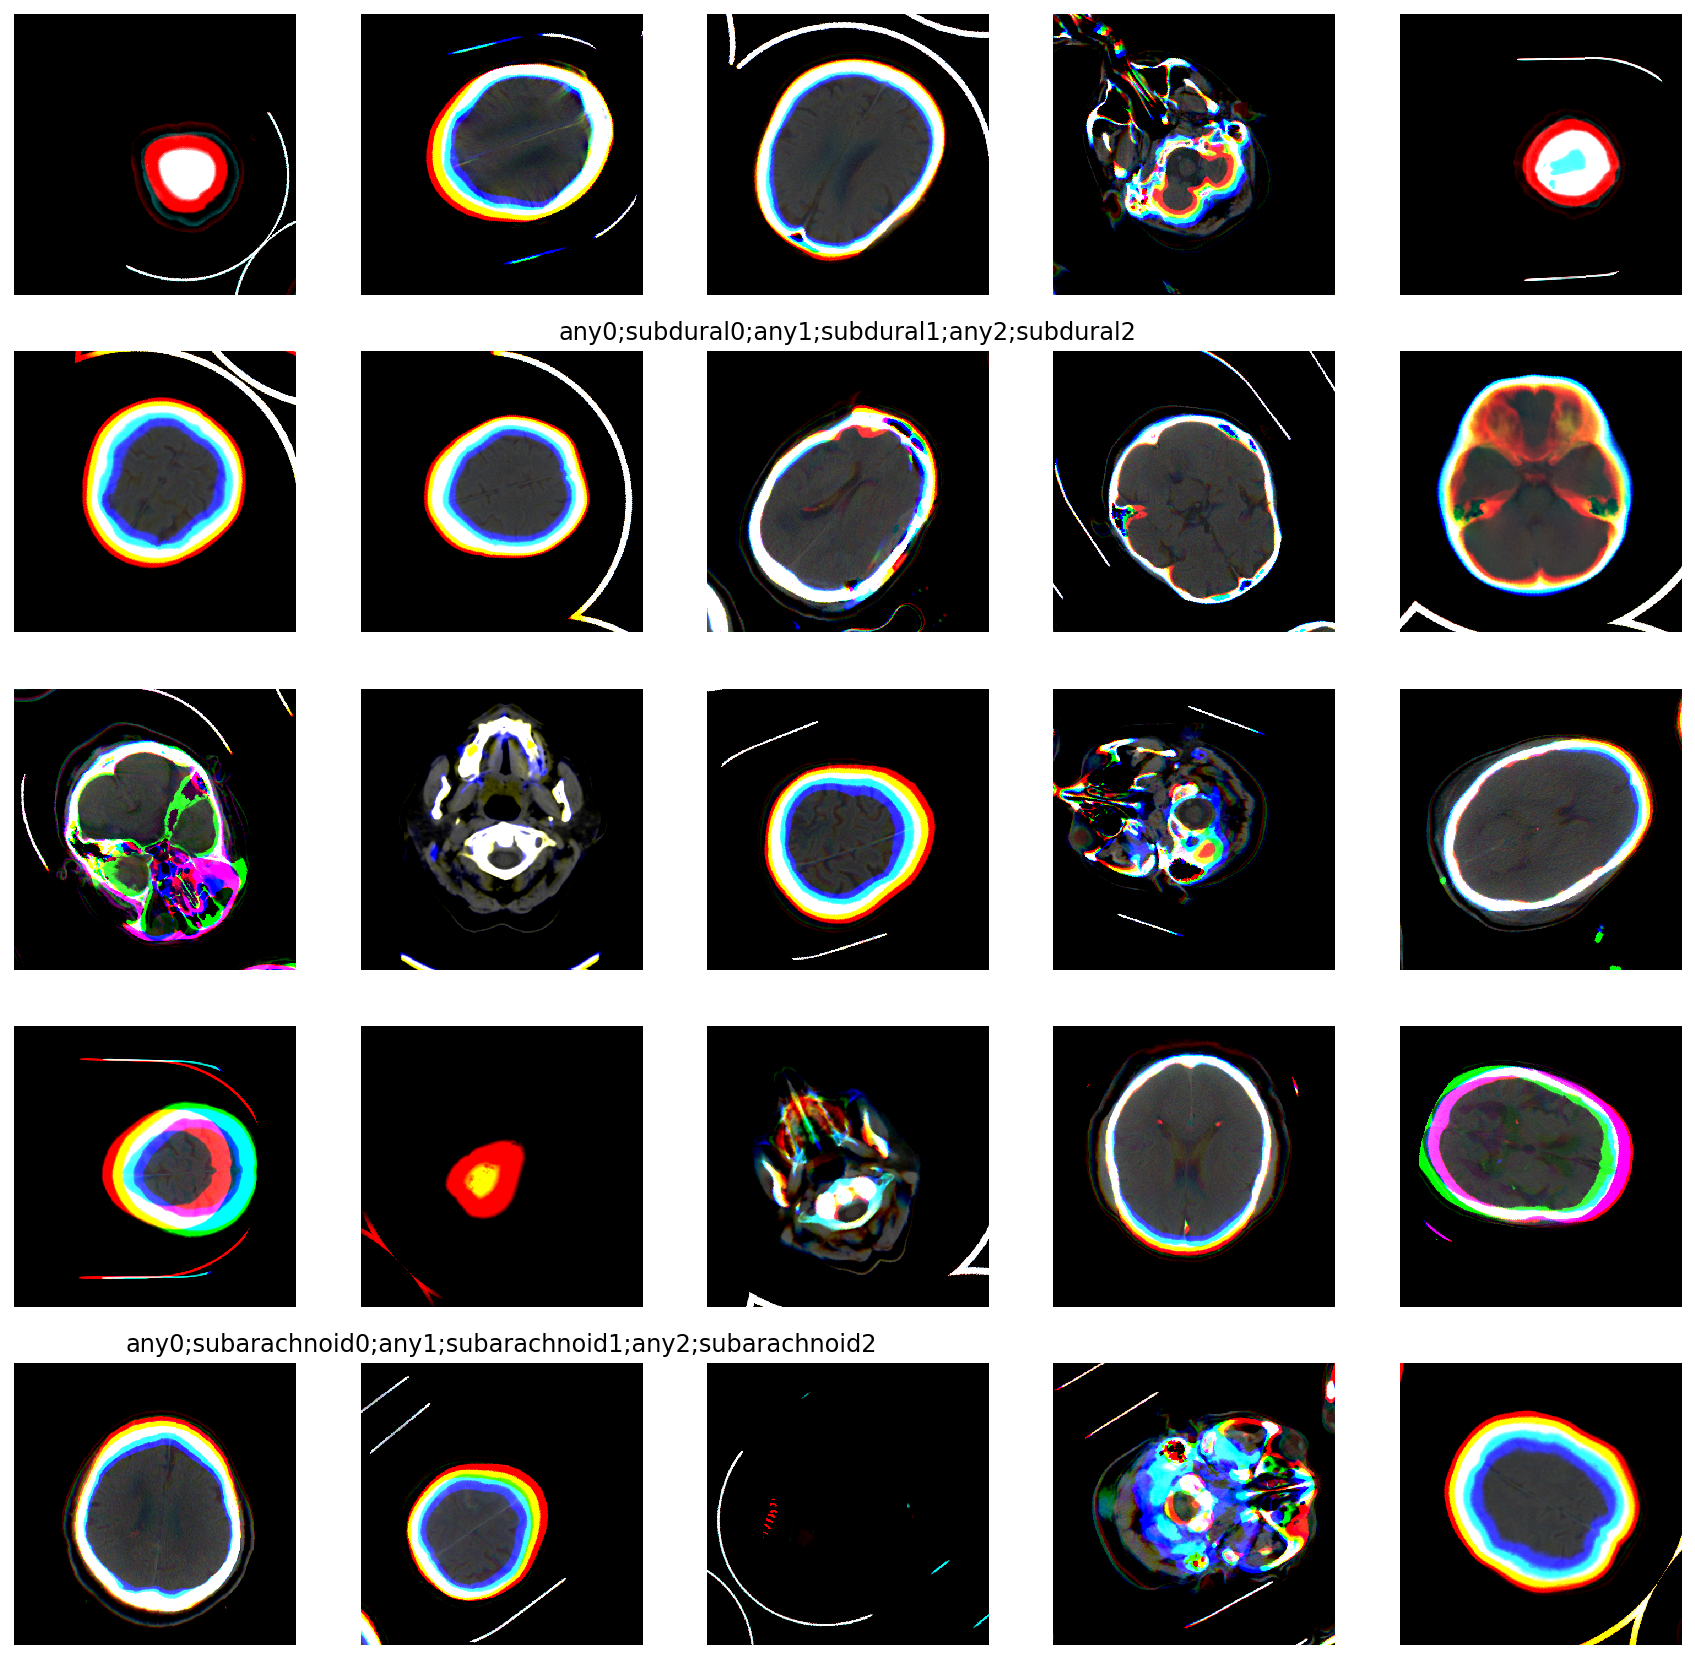

In [33]:
db.show_batch(max_n=25)

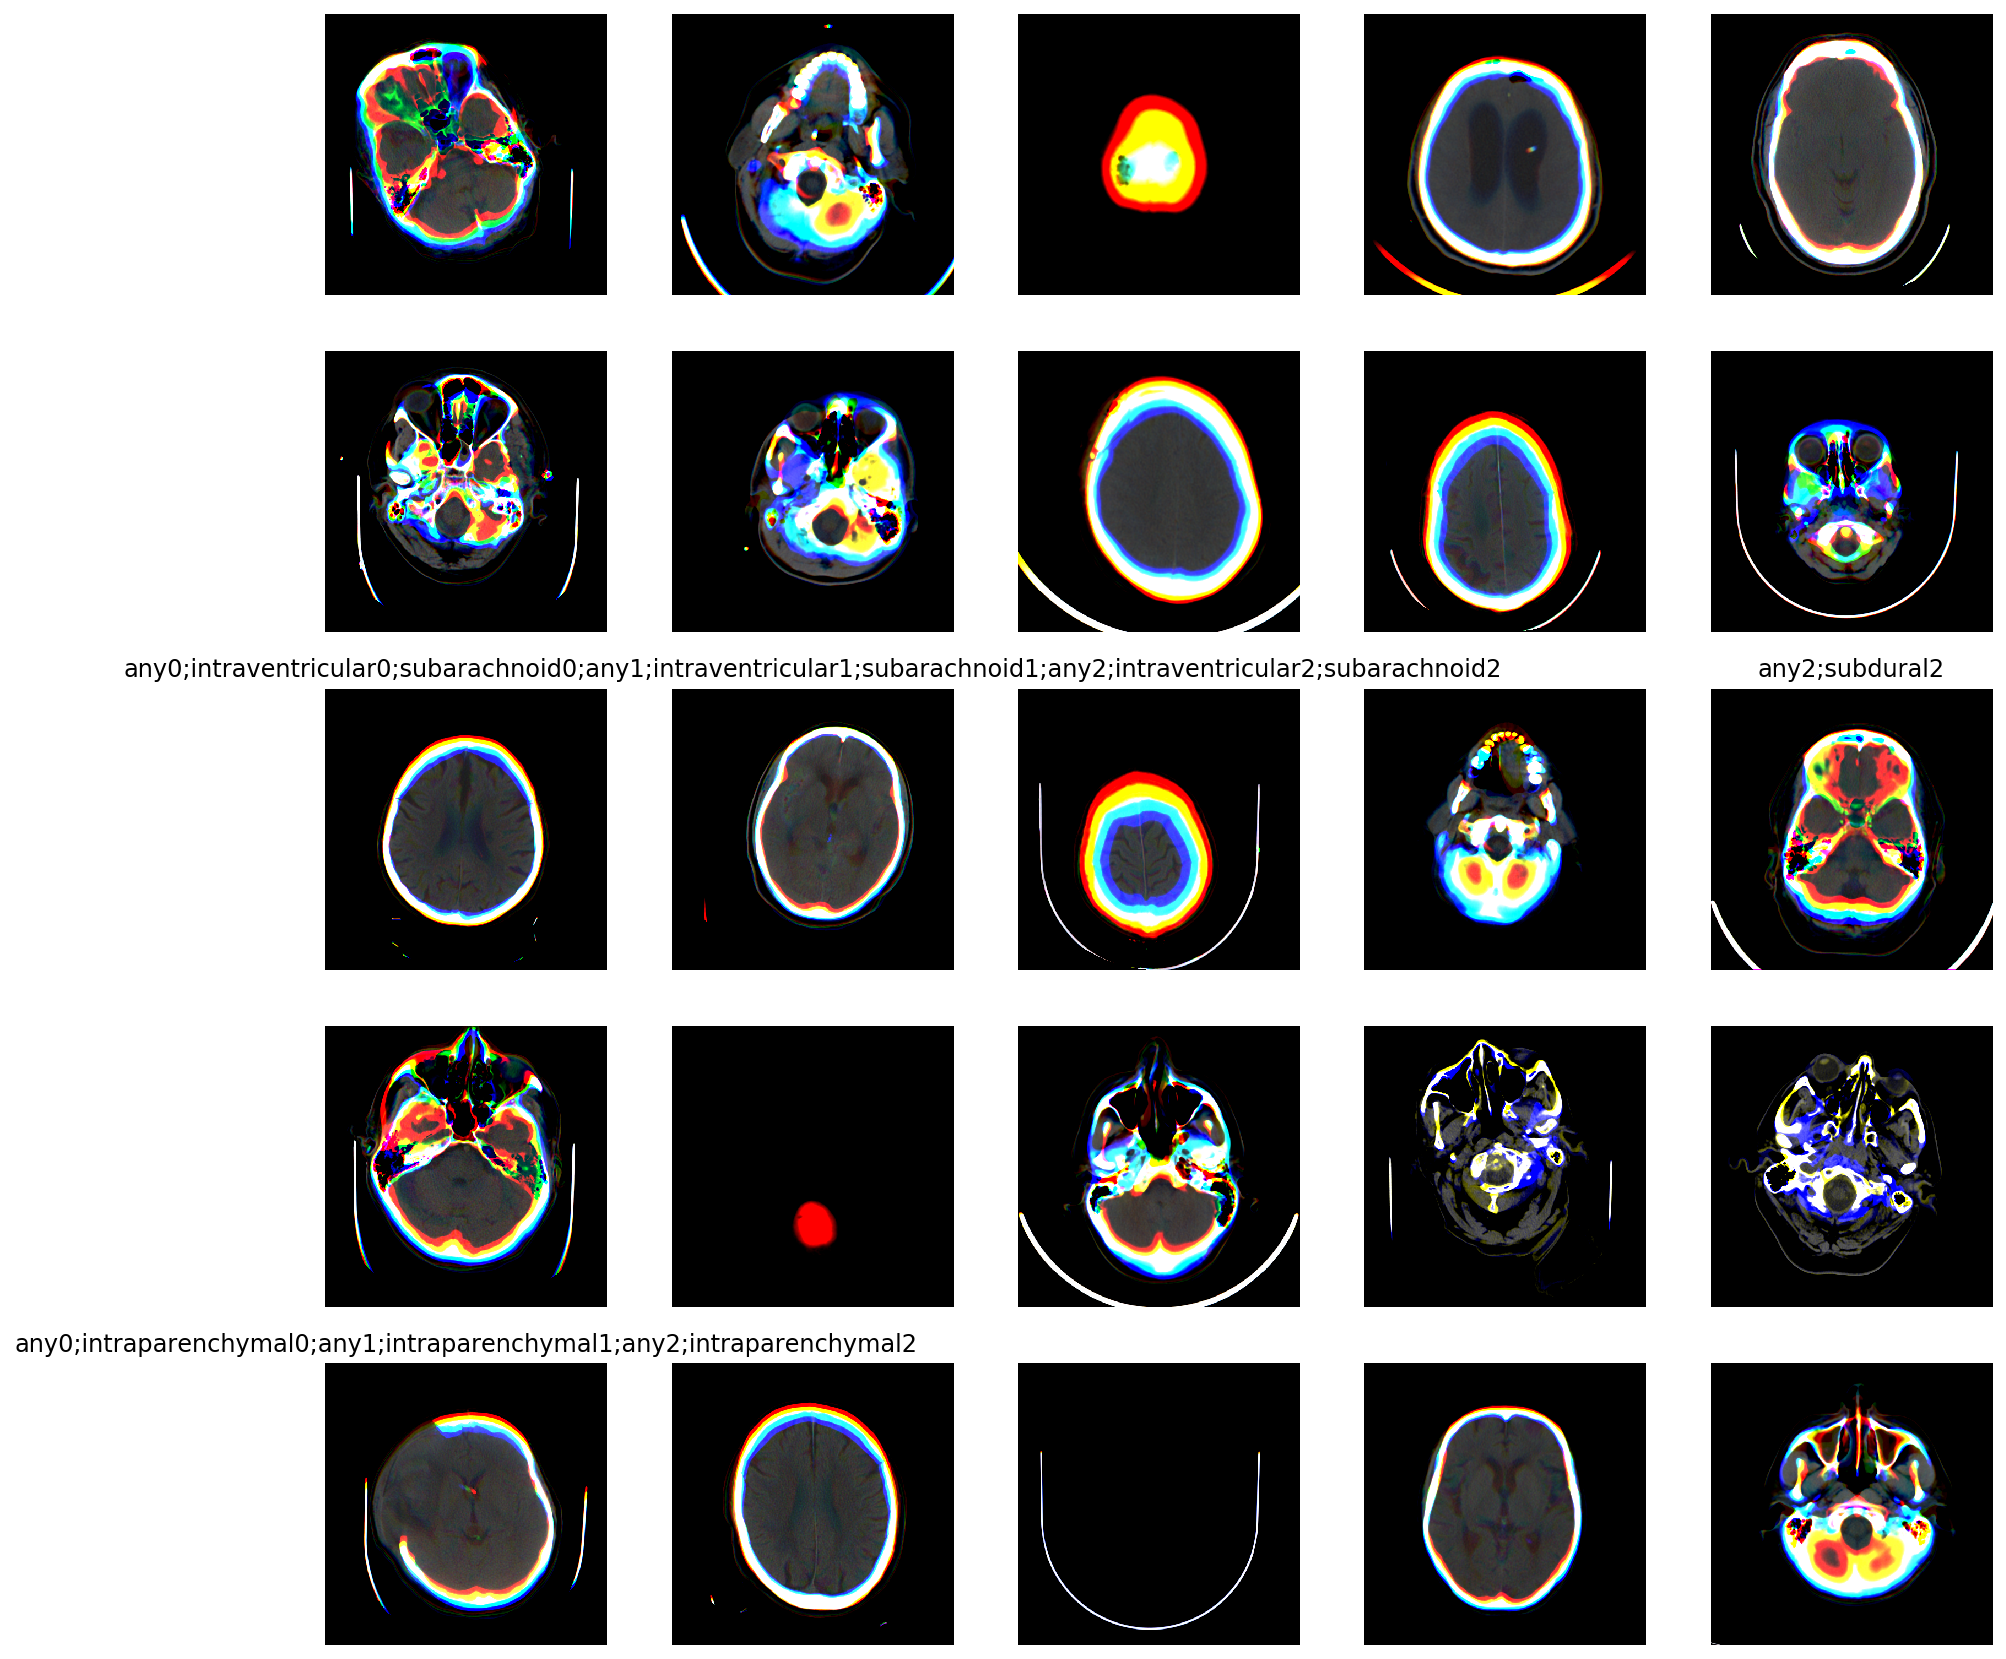

In [34]:
# Verify transforms on validation set
db.valid_dl.show_batch(max_n=25)

# Model

## Loss

In [35]:
GENERAL_WEIGHTS  = FloatTensor([2., 1., 1., 1., 1., 1.])
general_weights_3slices = torch.cat([GENERAL_WEIGHTS * W_LOSS, GENERAL_WEIGHTS, GENERAL_WEIGHTS * W_LOSS])

def weighted_loss(pred:Tensor,targ:Tensor)->Tensor:
    return F.binary_cross_entropy_with_logits(pred, targ.float(), general_weights_3slices.to(device=pred.device))

In [36]:
SUBDURAL_WEIGHTS = FloatTensor([.8, .4, .4, .4, .4, 4.])
subdural_weights_3slices = torch.cat([SUBDURAL_WEIGHTS * W_LOSS, SUBDURAL_WEIGHTS, SUBDURAL_WEIGHTS * W_LOSS])

def subdural_loss(pred:Tensor,targ:Tensor)->Tensor:
    return F.binary_cross_entropy_with_logits(pred, targ.float(), subdural_weights_3slices.to(device=pred.device))

## Metrics

In [37]:
real_lb_weights = FloatTensor([ 2, 1, 1, 1, 1, 1 ])

def real_lb_loss(pred:Tensor, targ:Tensor)->Tensor:
    pred,targ = flatten_check(pred,targ)
    tp = pred.view(-1,18)[:,6:12]
    tt = targ.view(-1,18)[:,6:12]
    return F.binary_cross_entropy_with_logits(tp, tt.float(), real_lb_weights.to(device=pred.device))

In [38]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,6],targ[:,6])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [39]:
def accuracy_subdural(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,11],targ[:,11])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [40]:
def UNUSED_get_loss(scale=1.0):
    '''
    From: https://www.kaggle.com/jhoward/from-prototyping-to-submission-fastai

    PRO: might save us from manually sigmoiding test preds
    CON: might not work because cuda device is not known at the time of creating the function?
    '''
    loss_weights = tensor(2.0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1).cuda()*scale
    return BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
        is_2d=False, activation=torch.sigmoid)

## Learner

In [41]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [42]:
learn = cnn_learner(
    db, 
    getattr(models, ARCH), 
    loss_func=subdural_loss, 
    opt_func=opt_func, 
    metrics=[real_lb_loss, accuracy_any, accuracy_subdural],
    config=cnn_config(lin_ftrs=[], ps=0.),
    model_dir = Path('./models/').resolve()
)
if torch.cuda.device_count() > 1: learn.to_parallel()
learn.to_fp16()

# Train

In [43]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
LR

In [ ]:
learn.fit_one_cycle(N_EPOCHS, slice(LR))

epoch,train_loss,valid_loss,real_lb_loss,accuracy_any,accuracy_subdural,time


# Save

In [ ]:
v = learn.recorder.values[-1]
cv = float(v[1]) # 0 = valid_loss, 1 = real_lb_loss
cv

In [ ]:
model_fn = f'{ARCH}-{experiment}_sz{SZ}_cv{cv:0.4f}_{learn.loss_func.__name__}_fold{FOLD+1}_of_{N_FOLDS}'
model_fn

In [ ]:
learn.save(model_fn)

# TTA

## Test predictions

In [ ]:
test_items = L(sorted(get_files(test_dir, ['.dcm'])))

In [ ]:
def tta_set(dsrc, test_items, rm_tfms=0):
    "JAVI @ core.py: Create a test set from `test_items` using **TRAIN** transforms of `dsrc`"
    test_tls = [tl._new(test_items, split_idx=0) for tl in dsrc.tls[:dsrc.n_inp]]
    rm_tfms = tuplify(rm_tfms, match=test_tls)
    for i,j in enumerate(rm_tfms): test_tls[i].tfms.fs = test_tls[i].tfms.fs[j:]
    return DataSource(tls=test_tls)

In [ ]:
def tta_dl(dbunch, test_items, rm_type_tfms=0, **kwargs):
    "JAVI @ core.py: Create a test dataloader from `test_items` using **TRAIN** transforms of `dbunch`"
    test_ds = tta_set(dbunch.valid_ds, test_items, rm_tfms=rm_type_tfms) if isinstance(dbunch.valid_ds, DataSource) else test_items
    return dbunch.valid_dl.new(test_ds, **kwargs)

In [ ]:
tdl = tta_dl(db, test_items)

In [ ]:
tdl.show_batch(max_n=25)

In [ ]:
test_preds = []
# Fastai WTF: it figures out to run outputs through sigmoid if a standard loss error is used 
# (see loss_func_name2activ and related stuff) but on custom loss funcs sigmoid must be executed explicitly:
# https://forums.fast.ai/t/shouldnt-we-able-to-pass-an-activ-function-to-learner-get-preds/50492
for _ in progress_bar(range(N_TTA)):
    preds, _ = learn.get_preds(dl=tdl, act=torch.sigmoid)
    test_preds.append(preds)
tta_test_preds = torch.stack(test_preds)

## Validation predictions

In [ ]:
valid_items = L(items)[split_idx[1]]

In [ ]:
vdl = tta_dl(db, valid_items)

In [ ]:
vdl.show_batch(max_n=25)

In [ ]:
valid_preds = []
# Fastai WTF: it figures out to run outputs through sigmoid if a standard loss error is used 
# (see loss_func_name2activ and related stuff) but on custom loss funcs sigmoid must be executed explicitly:
# https://forums.fast.ai/t/shouldnt-we-able-to-pass-an-activ-function-to-learner-get-preds/50492
for _ in progress_bar(range(N_TTA)):
    preds, _ = learn.get_preds(dl=vdl, act=torch.sigmoid)
    valid_preds.append(preds)
tta_valid_preds = torch.stack(valid_preds)

## Save predictions for L2 stacking

In [ ]:
PREDS_DIR = 'data/predictions'
!mkdir -p {PREDS_DIR}

In [ ]:
torch.save(tta_test_preds,  f'{PREDS_DIR}/{model_fn}_test.pth')
torch.save(tta_valid_preds, f'{PREDS_DIR}/{model_fn}_valid.pth')

In [ ]:
pd.DataFrame(
    {'fn': [p.stem for p in learn.dbunch.valid_ds.items]}).to_csv(f'{PREDS_DIR}/{model_fn}_valid_fns.csv',index=False)
pd.DataFrame(
    {'fn': [p.stem for p in test_items]}).to_csv(f'{PREDS_DIR}/{model_fn}_test_fns.csv',index=False)

# Submit to Kaggle

In [ ]:
tta_test_preds_mean = tta_test_preds.mean(dim=0)

In [ ]:
ids = []
labels = []

for fn, pred in zip(test_fns, tta_test_preds_mean):
    for i, label in enumerate(classes):
        if label.endswith('1'):
            ids.append(f"{fn.split('.')[0]}_{label.strip('1')}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)

In [ ]:
mkdir -p data/submissions

In [ ]:
sub_name = experiment_name + "_" + model_fn
sub_path = f'data/submissions/{sub_name}.csv.zip'
sub_name, sub_path

In [ ]:
pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(sub_path, compression='zip', index=False)

In [ ]:
!ls data/submissions/

In [ ]:
!echo {sub_path}

In [ ]:
!kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f {sub_path} -m {model_fn}

# Scratchpad

In [ ]:
Cuda.order